# Baseball Application of Denoising Methodologies

In this notebook we consider an application of two empirical Bayes denoising methods to a baseball data set, yielding Figure 6.2 from the arxiv version of the paper. Specifically, we focus on the question of inferring the latent disribution of batting skill for rookie players, jointly during the last minor-league and first major-league seasons.

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from npeb import *
import itertools
from scipy.linalg import inv, sqrtm
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

## Set up data

The data set is made from publicly-availble data on [Fangraphs](https://www.fangraphs.com/). A small amount of pre-processing is required, which we perform in `assets/make_baseball_dataset.ipynb`, and the results are saved in a `.pkl` file that we now upload.

In [2]:
rookies = np.load('assets/baseball_data.pkl', allow_pickle=True) 
rookies

,Name,minG,minRBI,majG,majRBI
0,Julio Rodriguez,74.0,47.0,132.0,75.0
1,Adley Rutschman,123.0,75.0,113.0,42.0
2,Michael Harris II,101.0,64.0,114.0,64.0
3,Brendan Donovan,108.0,66.0,126.0,45.0
4,Bobby Witt Jr.,123.0,97.0,150.0,80.0
...,...,...,...,...,...
319,Coby Mayo,140.0,99.0,17.0,0.0
320,Trey Lipscomb,129.0,72.0,61.0,10.0
321,Niko Goodrum,65.0,36.0,13.0,0.0
322,Justin Foscue,122.0,84.0,15.0,1.0


In [3]:
Z = np.vstack([rookies['minRBI'].values,rookies['majRBI'].values]).T
L = np.vstack([rookies['minG'].values/142,rookies['majG'].values/162]).T
n = Z.shape[0]

## Compute denoisers

Next, we compute the three empirical Bayes denoisers of interest for the rookies data. We do this by slightly modifying the `npeb` package to accommodate the bivariate Poisson likelihood.

### (Unconstrained) empirical Bayes

In [4]:
eb_model = PMixture()
eb_model.fit_bivariate_heteroskedastic(Z, L)
at, wt = eb_model.get_params()
eb = eb_model.posterior_mean_bivariate_heteroskedastic(Z,L)

M = np.max(eb)
x = np.linspace(0,M)

### Variance-constrained empirical Bayes

In [5]:
eb_mean = np.mean(eb,axis=0)
M_hat = (eb-eb_mean).T@(eb-eb_mean)/n
mu_hat = np.sum(at * wt.reshape(-1,1), axis=0)
A_hat = (at - mu_hat).T @ np.diag(wt) @ (at - mu_hat)
transport_hat = inv(sqrtm(M_hat))@sqrtm(sqrtm(M_hat)@A_hat@sqrtm(M_hat))@inv(sqrtm(M_hat))
emvcb = (eb - eb_mean)@transport_hat + mu_hat

### General-constrained empirical Bayes

In [6]:
M_min = 1.1*np.max(emvcb[:,0])
m_maj = 1.3*np.min(emvcb[:,1])
M_maj = 1.1*np.max(emvcb[:,1])
x = np.linspace(0,M_min)

In [7]:
k = 100
emgcb_min_min, emgcb_min_max = 0.8*np.min(emvcb[:,0]), 1.2*np.max(emvcb[:,0])
emgcb_maj_min, emgcb_maj_max = 0, 1.2*np.max(emvcb[:,1])

Eta_min = np.linspace(emgcb_min_min,emgcb_min_max,k)
Eta_maj = np.linspace(emgcb_maj_min,emgcb_maj_max,k)
Eta = np.array(list(itertools.product(Eta_min,Eta_maj)))
Eta = np.vstack([Eta, at])

In [8]:
pi = cp.Variable((n,k**2 + len(wt)))
C_hat = distance_matrix(eb, Eta)**2
objv = cp.Minimize(cp.sum(cp.multiply(C_hat, pi)))
emgcb = np.zeros((n,2))
H = cp.sum(pi, axis=0)

cstr = [pi >= 0, cp.sum(pi) == 1,
        cp.sum(pi, axis=1) == np.ones(n)/n,
        Eta.T @ H == mu_hat,
        (Eta - mu_hat).T @ cp.diag(H) @ (Eta - mu_hat) == A_hat]
problem = cp.Problem(objv,cstr)
problem.solve(solver='MOSEK',verbose=False)
pi_opt = pi.value
for i in range(n):
    emgcb[i,:] = (pi_opt[i,:].reshape(1,-1) @ Eta) / np.sum(pi_opt[i,:])

## Plotting

Lastly, we plot the observations (standardized with respect to exposure), along with the two empirical Bayes denoising methods of interest.

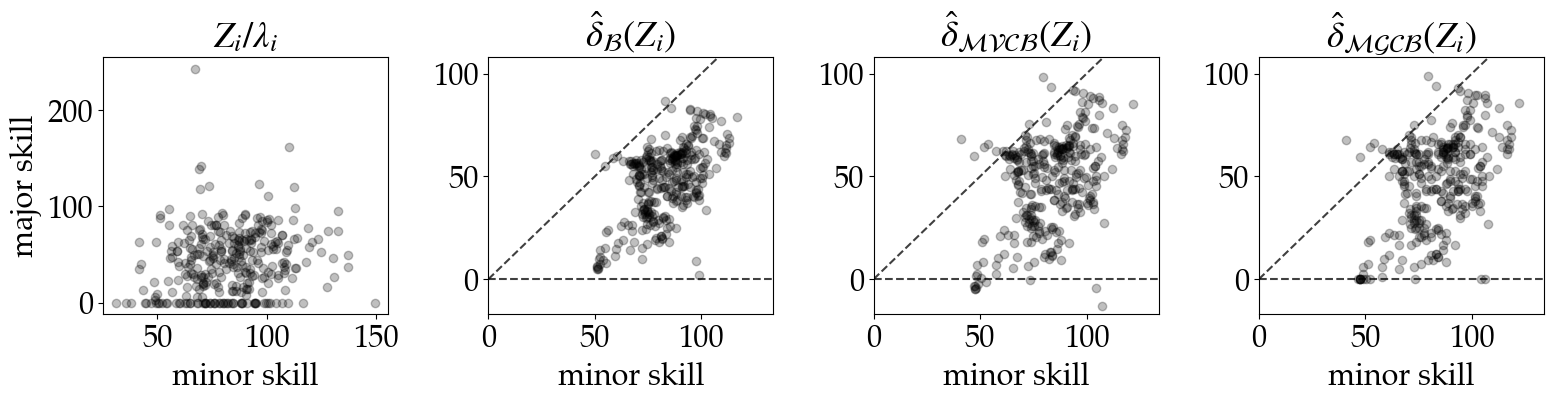

In [10]:
plt.rcParams.update({'font.size': 22,
                     'mathtext.fontset': 'stix',
                     'font.family': 'serif',
                     'font.serif':'Palatino'})


fig, ax = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(16,4.5))

ax[0].set_title('$Z_i/\\lambda_i$')
ax[0].set_ylabel('major skill')
ax[0].set_xlabel('minor skill')
ax[0].scatter(rookies['minRBI']/(rookies['minG']/142),rookies['majRBI']/(rookies['majG']/162), alpha=0.25, color='black')

ax[1].set_title('$\\hat{\\delta}_{\mathcal{B}}(Z_i)$')
ax[1].set_xlabel('minor skill')
ax[1].scatter(eb[:,0], eb[:,1], alpha=0.25, color='black')
ax[1].plot(x,x,color='black',linestyle='dashed',alpha=0.75)
ax[1].plot(x,np.zeros_like(x),color='black',linestyle='dashed',alpha=0.75)
ax[1].set_xlim([0,M_min])
ax[1].set_ylim([m_maj,M_maj])

ax[2].set_title('$\\hat{\\delta}_{\mathcal{MVCB}}(Z_i)$')
ax[2].set_xlabel('minor skill')
ax[2].scatter(emvcb[:,0], emvcb[:,1], alpha=0.25, color='black')
ax[2].plot(x,x,color='black',linestyle='dashed',alpha=0.75)
ax[2].plot(x,np.zeros_like(x),color='black',linestyle='dashed',alpha=0.75)
ax[2].sharex(ax[1])
ax[2].sharey(ax[1])

ax[3].set_title('$\\hat{\\delta}_{\mathcal{MGCB}}(Z_i)$')
ax[3].set_xlabel('minor skill')
ax[3].scatter(emgcb[:,0], emgcb[:,1], alpha=0.25, color='black')
ax[3].plot(x,x,color='black',linestyle='dashed',alpha=0.75)
ax[3].plot(x,np.zeros_like(x),color='black',linestyle='dashed',alpha=0.75)
ax[3].sharex(ax[1])
ax[3].sharey(ax[1])

plt.tight_layout()
plt.savefig('Baseball.pdf')
plt.savefig('Baseball.png')
plt.show()